(example-filters)=
# Add-drop filters

In this tutorial, we are designing a circuit called an Add-Drop Filter, with a
single input and multiple outputs.

## Deconstruction

An add-drop filter uses rings of different radii to select specific frequencies
from an input waveguide and convey them to an output.

```{eval-rst}
.. figure:: /_static/images/filters.png
    :alt: Add-Drop Filter
    :align: center

    A sample Add-Drop Filter. The rings all have differing
    radii.
```

Light travels through the input waveguide, and some frequencies carry over to the ring waveguides, depending on the
radius of the ring. These signals move along the ring until they transfer over to the output waveguides, giving us a
reading on what frequencies of light traveled through the input. Light is designed to travel only in one direction after
reaching the output waveguides, but we must account for backwards scattering light. We simply add a terminator at the
other end of the output waveguides to diffuse any such light.

Notice how the Add-Drop Filter is composed of three similar rings, differing only by their radius:

```{eval-rst}
.. figure:: /_static/images/ring.png
    :align: center

    An isolated, single ring resonator.
```

This single ring resonator can be defined using models from both SiEPIC and SiPANN libraries in Simphony. Instead of
defining each model for each ring resonator sequentially, we can use the subcircuit pattern: we will
create a method that defines a ring resonator for us from two half rings.

## Subcircuit pattern

First, we need to import the libraries we need. The SiEPIC
library, the sweep simulator, and matplotlib will be used,
just as last tutorial. In addition, we need the SiPANN 
library. This library of models is not included by default
in Simphony, but it integrates well. You will need to 
install it as shown in the [SiPANN docs](https://sipann.readthedocs.io/en/latest/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sax

from simphony.libraries import siepic, sipann
from simphony.classical import ClassicalSim

2023-11-14 13:42:03.651114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:tensorflow:Restoring parameters from /home/parkeraa/Github/simenv/lib/python3.10/site-packages/SiPANN/ANN/TIGHT_ANGLE_GAP/model
INFO:tensorflow:Restoring parameters from /home/parkeraa/Github/simenv/lib/python3.10/site-packages/SiPANN/ANN/TIGHT_ANGLE_STRAIGHT/model
INFO:tensorflow:Restoring parameters from /home/parkeraa/Github/simenv/lib/python3.10/site-packages/SiPANN/ANN/TIGHT_ANGLE_BENT_RAND/model


We now create the method that generates a ring resonator for us. We pass in the radius as a parameter, and the return value is a 
SAX s-dictionary. This means the API resembles that of a model--and can be used much the same way a model can. Note that your new model, made up of other models, masks their parameters; only the parameters your model takes can be passed along to the submodels.

```{note} 

The ``partial`` function is a Python function that allows you to create a new function from an existing function, but with some parameters already filled in. In this case, we are creating a new function that takes only the radius as a parameter, and returns a ring resonator with that radius. This is useful because we can set new default parameters for arguments of the new function, and we can pass the new function around as a parameter to other functions. This is a very powerful tool in Python, and we will use it often in simulations.
```

In [6]:
from functools import partial


def ring_factory(wl=1.55, radius=10) -> sax.SDict:
    """Creates a full ring (with terminator) from a half ring.

    Resulting pins are ('through', 'drop', 'in', 'out').

    Parameters
    ----------
    wl : ArrayLike
        The wavelengths to simulate at, in microns.
    radius : float
        The radius of the ring resonator, in microns.
    """
    # Create rings for selecting out frequencies from the data line.
    # See simphony's SiPANN model library API for argument order and units.
    cir, info = sax.circuit(
        netlist={
            "instances": {
                "ring1": "half_ring",
                "ring2": "half_ring",
            },
            "connections": {
                "ring1,o1": "ring2,o3",
                "ring2,o1": "ring1,o3",
            },
            "ports": {
                "in": "ring1,o0",
                "through": "ring1,o2",
                "drop": "ring2,o2",
                "add": "ring2,o0",
            }
        },
        models={
            "half_ring": partial(sipann.half_ring, wl=wl, width=500, thickness=220, radius=radius, gap=100),
        }
    )
    # Return the composite model.
    return cir(wl=wl)

Before we construct the full Add-Drop Filter, we can run a simulation on a single ring to make sure everything is
behaving as expected.

In [7]:
wl = np.linspace(1.5, 1.6, 1000)
ring1 = ring_factory(wl=wl, radius=10)

plt.plot(wl, np.abs(ring1['in', 'through'])**2, label="through")
plt.plot(wl, np.abs(ring1['in', 'drop'])**2, label="drop")
plt.plot(wl, np.abs(ring1['in', 'add'])**2, label="add")
plt.title("10-micron Ring Resonator")
plt.xlabel("Wavelength (microns)")
plt.legend()
plt.tight_layout()
plt.show()

TypeError: len() of unsized object

*The through-, add-, and drop-port frequency response of a 10 micron ring resonator.*

Now that we've created and tested our ``ring_factory``
method, we can use it to define the Add-Drop Filter.

## Defining the circuit

Let's create our composite circuit by connecting each component as shown in the diagram:

In [5]:
filter_cir, info = sax.circuit(
    netlist={
        "instances": {
            "ring1": "ring",
            "ring2": "ring",
            "ring3": "ring",
        },
        "connections": {
            "ring1,through": "ring2,in",
            "ring2,through": "ring3,in",
        },
        "ports": {
            "in": "ring1,in",
            "out1": "ring1,drop",
            "out2": "ring2,drop",
            "out3": "ring3,drop",
        },
    },
    models={
        "ring": ring_factory,
    }
)

TypeError: len() of unsized object

Now we're ready to simulate.

## Simulation

We'll run a sweep simulation, but we're reducing the frequency range to 1524.5-1551.15 nm, instead of a full 1500-1600
nm sweep as we have done previously. This will show us a simpler graph of only a few peaks that the filter picks out.
We'll be using more advanced matplotlib features here (reference the [matplotlib docs](https://matplotlib.org/) on these).

We simulate by creating an array of our wavelengths of interest and passing it along with model parameters to the callable
function representing our circuit. We know that it will return a dictionary of S-parameters, where the keys are tuples
of port relationships, so we will name this ``S``. I've created a rather odd wavelength range here, but only because I already
know what range will make for the prettiest graph.

In [ ]:
wl = np.linspace(1.5245, 1.55115, 1000)
S = filter_cir(wl=wl, ring1={"radius": 10}, ring2={"radius": 11}, ring3={"radius": 12})

Let's plot the three outputs. There is one point where all the peaks will overlap; we're going to pull this out into a separate plot on the side.

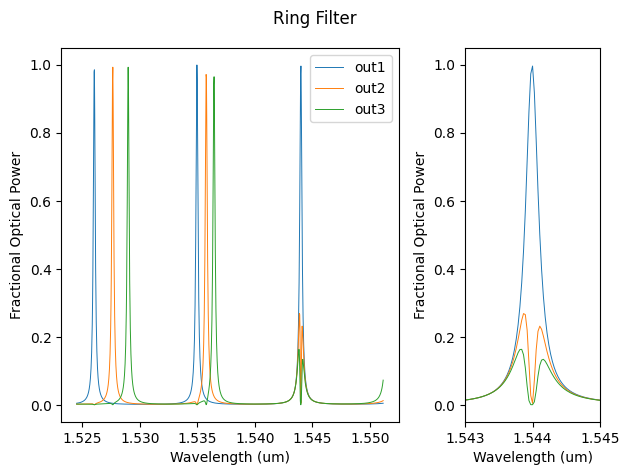

In [23]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(1, 3)

# Plot the three outputs over the full simulated wavelength range.
ax = fig.add_subplot(gs[0, :2])
ax.plot(wl, np.abs(S['in', 'out1'])**2, label="out1", lw=0.7)
ax.plot(wl, np.abs(S['in', 'out2'])**2, label="out2", lw=0.7)
ax.plot(wl, np.abs(S['in', 'out3'])**2, label="out3", lw=0.7)
ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (um)")
ax.legend(loc="upper right")

# Plot the three outputs over a restricted wavelength range.
ax = fig.add_subplot(gs[0, 2])
ax.plot(wl, np.abs(S['in', 'out1'])**2, label="out1", lw=0.7)
ax.plot(wl, np.abs(S['in', 'out2'])**2, label="out2", lw=0.7)
ax.plot(wl, np.abs(S['in', 'out3'])**2, label="out3", lw=0.7)
ax.set_xlim(1.543, 1.545)
ax.set_ylabel("Fractional Optical Power")
ax.set_xlabel("Wavelength (um)")

plt.suptitle("Ring Filter")
fig.align_labels()
plt.show()

*The response of our designed add-drop filter.*